# Example with torus

First, we take samples from a torus and compute the distance matrix.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [24]:
import scipy.spatial.distance as dist

from permaviss.sample_point_clouds.examples import random_cube, take_sample

X = random_cube(1000,3)
point_cloud = take_sample(X,130)

Dist = dist.squareform(dist.pdist(point_cloud))

## Compute ordinary Persistent Homology

In [25]:
from permaviss.simplicial_complexes.vietoris_rips import vietoris_rips
from permaviss.simplicial_complexes.differentials import complex_differentials
from permaviss.persistence_algebra.PH_classic import persistent_homology

In [27]:
max_r = 0.36
max_dim = 3
p = 3

C, R = vietoris_rips(Dist, max_r, max_dim)
Diff = complex_differentials(C, p)
PerHom, Im, PreIm = persistent_homology(Diff, R, max_r, p)
print(PerHom[2])

Barcode basis
[[ 0.27215782  0.2854356 ]
 [ 0.2731046   0.3052677 ]
 [ 0.28513426  0.29471942]
 [ 0.28966883  0.34133863]
 [ 0.29797088  0.31247907]
 [ 0.30439544  0.33188383]
 [ 0.31327963  0.33797832]
 [ 0.31438785  0.36      ]
 [ 0.31763753  0.31973146]
 [ 0.32087361  0.36      ]
 [ 0.32104401  0.36      ]
 [ 0.32216589  0.36      ]
 [ 0.32465446  0.34561281]
 [ 0.32571407  0.36      ]
 [ 0.32622137  0.33867912]
 [ 0.34279786  0.35344006]
 [ 0.34307782  0.35518521]
 [ 0.34803805  0.35446746]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]



## Plot Random Complex

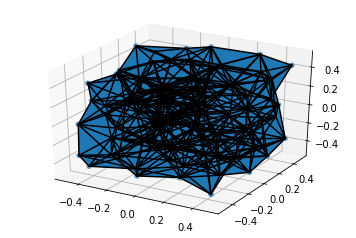

In [11]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(point_cloud[:,0], point_cloud[:,1], point_cloud[:,2])

for edge in C[1]:
    start_point = point_cloud[edge[0]]
    end_point = point_cloud[edge[1]]
    ax.plot([start_point[0], end_point[0]],
           [start_point[1], end_point[1]],
           [start_point[2], end_point[2]], color='k')
  

poly3d = []
for face in C[2]:
    triangles = []
    for pt in face:
        triangles.append(point_cloud[pt])
        
    poly3d.append(triangles)
    
ax.add_collection3d(Poly3DCollection(poly3d, linewidths=1, alpha=0.1))

plt.show()

## Now, do the same computation using the Mayer-Vietoris spectral sequence

We take the same max_r, max_dim and p as before. Additionally, we set max_div, which is the number of divisions along the coordinate with greater range. Also, we set the overlap between neighbouring regions to be slightly greater than max_r. The result will be the Persistent Mayer-Vietoris spectral sequence associated to this cover. Also, we compare this with the previous persistent homology computation. Both are equal.

In [12]:
from permaviss.spectral_sequence.MV_spectral_seq import create_MV_ss

max_div = 2
overlap = max_r*1.01

MV_ss = create_MV_ss(point_cloud, max_r, max_dim, max_div, overlap, p)

PAGE: 1
[[ 22   3   0   0   0   0   0   0   0]
 [126  63  16   4   0   0   0   0   0]
 [253 305 288 240 168  84  24   3   0]]
PAGE: 2
[[ 19   0   0   0   0   0   0   0   0]
 [ 75   2   0   0   0   0   0   0   0]
 [101   2   0   0   0   0   0   0   0]]
PAGE: 3
[[ 19   0   0   0   0   0   0   0   0]
 [ 75   2   0   0   0   0   0   0   0]
 [101   2   0   0   0   0   0   0   0]]
PAGE: 4
[[ 19   0   0   0   0   0   0   0   0]
 [ 75   2   0   0   0   0   0   0   0]
 [101   2   0   0   0   0   0   0   0]]


In [23]:
print(MV_ss.persistent_homology[1].dim)
bars_to_extend = MV_ss.Hom[3][1][0].barcode
print(bars_to_extend)
print("to extend")
for b in MV_ss.Hom[3][0][1].barcode:
    if b[0] in bars_to_extend[:,1]:
        print(b)
        
print("result")
for b in MV_ss.persistent_homology[1].barcode:
    if b[0] in bars_to_extend[:,0]:
        print(b)
        
print("expected")
for b in PerHom[1].barcode:
    if b[0] in bars_to_extend[:,0]:
        print(b)

75
[[ 0.2297222   0.23501615]
 [ 0.27102529  0.28902106]]
to extend
[ 0.23501615  0.35296262]
[ 0.23501615  0.31508622]
[ 0.28902106  0.33148888]
result
[ 0.2297222   0.31508622]
[ 0.27102529  0.33148888]
expected
[ 0.2297222   0.31508622]
[ 0.27102529  0.33148888]


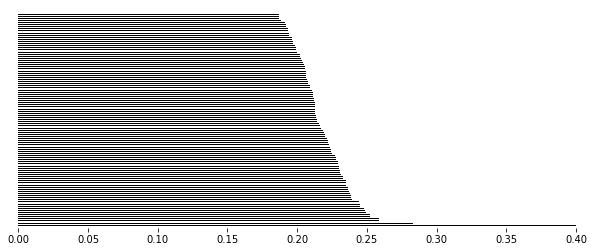

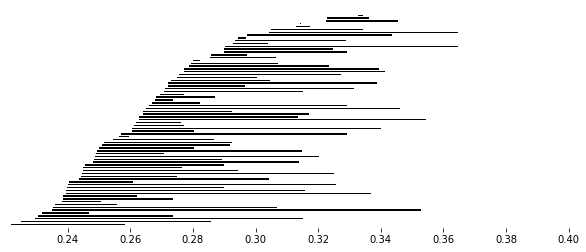

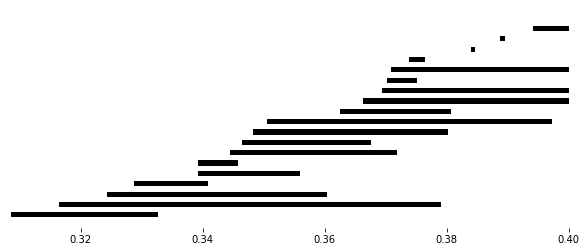

In [13]:
for it, PH in enumerate(MV_ss.persistent_homology):
    # print(PH.barcode)
    min_r = min(PH.barcode[0,:])
    assert np.array_equal(PH.barcode, PerHom[it].barcode)
    step = max_r/PH.dim
    width = step / 2.
    fig, ax = plt.subplots(figsize = (10,4))
    ax = plt.axes(frameon=False)
    y_coord = 0
    # Plot barcodes
    for k, b in enumerate(PH.barcode):
        ax.fill([b[0],b[1],b[1],b[0]],[y_coord,y_coord,y_coord+width,y_coord+width],'black',label='H0')
        y_coord += step
  

    # Show figure 
    ax.axes.get_yaxis().set_visible(False)
    ax.set_xlim([min_r,max_r])
    ax.set_ylim([-step, max_r + step])
    plt.savefig("barcode_r{}.png".format(it))
    plt.show()